# Applied Data Visualization – APIs

In this lecture we will explore how we can extract data from web-APIs. The first part of this tutorial is based on [this blog](https://www.dataquest.io/blog/python-api-tutorial/).

API stands for Application Programming Interface. It is supposed to be a **well defined interface** for consuming data (in contrast to web-scraping), or, more generally, for the **interaction with a remote program** on a server. APIs aren't only generated so that you can read data; they're often designed so that you could write custom software to interact with the API. You could, for example, write your own GitHub client! 

APIs are usually well documented, as the organization that provides APIs wants you to use them. 

Here are a couple of examples of sites that have documented APIs:

 * [GitHub](https://docs.github.com/en/rest?apiVersion=2022-11-28)
 * [StackExchange](https://api.stackexchange.com/docs)  
 * [Twitter](https://dev.twitter.com/rest/public)
 * [Facebook](https://developers.facebook.com/docs/graph-api)
 * [KEGG](http://www.genome.jp/kegg/rest/keggapi.html) 
 * [Google Maps](https://developers.google.com/maps/) 
 * and many many more. 
 
Most APIs require some form of authentication and have rules on what you're allowed to do and what not. Follow those rules, or you will be blocked faster than you can say `GET`. 
 
Working with an API is a lot like working with a website, but instead of a human in front of the screen, it's computers talking to each other. 

We'll be using the dominant form of APIs on the web: REST (REpresentational State Transfer). REST APIs use an [URI](https://en.wikipedia.org/wiki/Uniform_Resource_Identifier) (a Uniform Resource Identifier; URLs are one specific form of URIs) to specify what you want to do with and API.

All API methods in REST are relative to a base URL. E.g., for twitter this would be
```
https://api.twitter.com/1.1/
```

A query would look like this: 

```
https://api.twitter.com/1.1/search/tweets.json?q=%40twitterapi
```


REST APIs can return data in different forms. The most common ones are JSON and XML, and of those two, JSON is now dominant. 

JSON stands for JavaScript Object Notation, and is a pretty convenient format, as we'll see. 
 

Let's start with a very simple example, retrieving the current position of the ISS. We will be using the [requests library](http://www.python-requests.org/en/latest/), which will handle our communication with the server.

In [12]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('default')
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'pdf')

In [1]:
import requests 
# Make a get request to get the latest position of the international space station from the opennotify api.
response = requests.get("http://api.open-notify.org/iss-now.json")

response

<Response [200]>

That looks good, we've received a response with the message "200". What does the 200 mean? It's a status code - you've probably seen the "Error 404" on the internet. 

Here are a couple of codes:

 * **200** – everything went okay, and the result has been returned (if any)
 * **301** – the server is redirecting you to a different endpoint. This can happen when an organization switches domain names, or an endpoint name is changed.
 * **401** – the server thinks you’re not authenticated. This happens when you don’t send the right credentials to access an API (we’ll talk about authentication later).
 * **400** – the server thinks you made a bad request. This can happen when you don’t send along the right data, among other things.
 * **403** – the resource you’re trying to access is forbidden – you don’t have the right permissions to see it.
 * **404** – the resource you tried to access wasn’t found on the server.

Let's try to get a response with a wrong URL:

In [2]:
response_failed = requests.get("http://api.open-notify.org/iss")

response_failed

<Response [404]>

We used the get methods to put in a GET request. There are four different types of requests: 

![Request types](requests.png)
[Source](https://en.wikipedia.org/wiki/Representational_state_transfer)

Let's look at the payload of our previous, successful response:

In [3]:
response.content

b'{"iss_position": {"latitude": "34.7994", "longitude": "30.0105"}, "message": "success", "timestamp": 1699895686}'

We can already see that this is JSON (though it is stored a `bytes` object), but we can check formally:

In [4]:
response.headers['content-type']

'application/json'

We can decode this byte object, then the JSON will be readable. 

In [5]:
response_j = response.content.decode("utf-8")
print(response_j)

{"iss_position": {"latitude": "34.7994", "longitude": "30.0105"}, "message": "success", "timestamp": 1699895686}


Let's take a look at the JSON with nice formatting here:

```JSON
{
  "iss_position": {
    "latitude": -30.005751854107206, 
    "longitude": -104.20085371352678
  }, 
  "message": "success", 
  "timestamp": 1699895686
}
```

This looks a lot like a dictionary (or objects, for that matter)! We have key-value pairs. 

We can use the [json library](https://docs.python.org/3/library/json.html) to convert JSON into objects:

In [6]:
import json
response_d = json.loads(response_j)
print(type(response_d))
print(response_d)
response_d["iss_position"]

<class 'dict'>
{'iss_position': {'latitude': '34.7994', 'longitude': '30.0105'}, 'message': 'success', 'timestamp': 1699895686}


{'latitude': '34.7994', 'longitude': '30.0105'}

Or, not surprisingly, pandas can also load a json object:

In [7]:
df = pd.read_json(response_j)
df

,iss_position,message,timestamp
latitude,34.7994,success,2023-11-13 17:14:46
longitude,30.0105,success,2023-11-13 17:14:46


This isn't quite what we want - we probably want one row per timestamp and longitude and latitude as columns:

In [8]:
def flatten(response_d):
    response_flat = {}
    response_flat["latitude"] = response_d["iss_position"]["latitude"]
    response_flat["longitude"] = response_d["iss_position"]["longitude"]
    response_flat["timestamp"] = response_d["timestamp"]
    return response_flat
flatten(response_d)

{'latitude': '34.7994', 'longitude': '30.0105', 'timestamp': 1699895686}

That looks better. Let's get a couple of positions of the ISS over time and save it as an array:

In [9]:
import time

def pull_position():
    """Retreives the position of the ISS and returns it as a flat dictionary"""
    response = requests.get("http://api.open-notify.org/iss-now.json")
    response_j = response.content.decode("utf-8")
    response_d = json.loads(response_j)
    flat_response = flatten(response_d)
    return flat_response    

iss_position = []
    
# calls pull_position 10 times with 3 seconds break
for i in range(10):
    flat_response = pull_position()
    iss_position.append(flat_response)
    print(flat_response)
    time.sleep(3)
    
len(iss_position)

{'latitude': '43.0330', 'longitude': '43.3891', 'timestamp': 1699895900}
{'latitude': '43.1354', 'longitude': '43.6026', 'timestamp': 1699895903}
{'latitude': '43.2373', 'longitude': '43.8168', 'timestamp': 1699895906}
{'latitude': '43.3388', 'longitude': '44.0318', 'timestamp': 1699895909}
{'latitude': '43.4398', 'longitude': '44.2475', 'timestamp': 1699895912}
{'latitude': '43.5571', 'longitude': '44.5003', 'timestamp': 1699895915}
{'latitude': '43.6571', 'longitude': '44.7177', 'timestamp': 1699895918}
{'latitude': '43.7567', 'longitude': '44.9359', 'timestamp': 1699895921}
{'latitude': '43.8557', 'longitude': '45.1548', 'timestamp': 1699895924}
{'latitude': '43.9543', 'longitude': '45.3745', 'timestamp': 1699895927}


10

Now we can convert this into a nice dataframe:

In [10]:
iss_position_df = pd.DataFrame(iss_position)
iss_position_df['timestamp']  = pd.to_datetime(iss_position_df['timestamp'], unit="s")

iss_position_df = iss_position_df.set_index(pd.DatetimeIndex(iss_position_df['timestamp']))
iss_position_df["latitude"] = iss_position_df["latitude"].map(float)
iss_position_df["longitude"] = iss_position_df["longitude"].map(float)
iss_position_df

,latitude,longitude,timestamp
timestamp,,,
2023-11-13 17:18:20,43.0330,43.3891,2023-11-13 17:18:20
2023-11-13 17:18:23,43.1354,43.6026,2023-11-13 17:18:23
2023-11-13 17:18:26,43.2373,43.8168,2023-11-13 17:18:26
2023-11-13 17:18:29,43.3388,44.0318,2023-11-13 17:18:29
2023-11-13 17:18:32,43.4398,44.2475,2023-11-13 17:18:32
2023-11-13 17:18:35,43.5571,44.5003,2023-11-13 17:18:35
2023-11-13 17:18:38,43.6571,44.7177,2023-11-13 17:18:38
2023-11-13 17:18:41,43.7567,44.9359,2023-11-13 17:18:41
2023-11-13 17:18:44,43.8557,45.1548,2023-11-13 17:18:44


Let's see how the ISS moves

<Axes: xlabel='latitude', ylabel='longitude'>

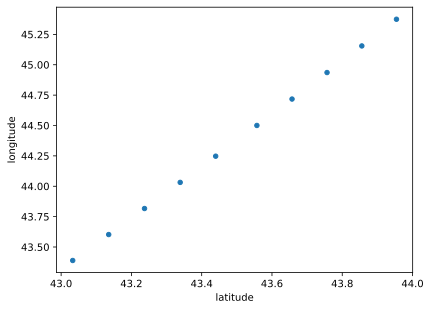

In [13]:
iss_position_df.plot(kind="scatter", x="latitude", y="longitude")

### Exercise: How many Astronauts? 

Use the [Open Notify API](http://open-notify.org/Open-Notify-API/People-In-Space/) to find out how many people are in space right now.

In [ ]:
# your code

## Libraries and Authentication

While we now have the skills to directly talk to an API, it's sometimes a little tedious. Popular APIs often have existing Python libraries that wrap around them. [Here](https://github.com/realpython/list-of-python-api-wrappers) is a long list of wrappers! 

Now we'll explore the GitHub API using the [PyGithub library](https://github.com/PyGithub/PyGithub). Check out the [documentation](https://pygithub.readthedocs.io/en/stable/).




In [16]:
#!pip install PyGitHub 

  Obtaining dependency information for PyGitHub from https://files.pythonhosted.org/packages/be/04/810d131be173cba445d3658a45512b2b2b3d0960d52c4a300d6ec5e00f52/PyGithub-2.1.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.9/349.9 kB 4.5 MB/s eta 0:00:00a 0:00:01
  Obtaining dependency information for pyjwt[crypto]>=2.4.0 from https://files.pythonhosted.org/packages/2b/4f/e04a8067c7c96c364cef7ef73906504e2f40d690811c021e1a1901473a19/PyJWT-2.8.0-py3-none-any.whl.metadata
  Obtaining dependency information for Deprecated from https://files.pythonhosted.org/packages/20/8d/778b7d51b981a96554f29136cd59ca7880bf58094338085bcf2a979a0e6a/Deprecated-1.2.14-py2.py3-none-any.whl.metadata
  Obtaining dependency information for cryptography>=3.4.0 from https://files.pythonhosted.org/packages/0b/c1/2f1e8abb31ec0bf8b004052bbe0face0a8be386ed5ea30e5e300bfffd51a/cryptography-41.0.5-cp37-abi3-macosx_10_12_universal2.whl.metadata
  Obtaining dependency information for wrapt<2,>=1.


Unfortunately, most professional APIs will require you to authenticate and will limit you in what you can do – mostly they limit how much data you can retreive at a certain time. To run the following code, you'll have to put in your own credentials (sorry – I can't share mine). 

You'll need to [create a personal access token](https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/creating-a-personal-access-token)
and save it in a file `credentials.py` in the format:
```python
CONSUMER_KEY = "KEY"
CONSUMER_SECRET = "KEY"
```



In [ ]:
from twython import Twython
# credentials is a local file with your own credentials. It defines CONSUMER_KEY and CONSUMER_SECRET
# you will have to load your own credentials here.
from credentials_alex import * 
twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET)

Here, we have created the Twython library object and authenticated against our user.

Now let's search for a hashtag:

In [ ]:
tag = "#resist"
result = twitter.search(q=tag, tweet_mode="extended")
result

The result is an array of tweets, we can look at specific text:

In [ ]:
result["statuses"][0]["full_text"]

Or print all the tweets:

In [ ]:
for status in result["statuses"]:
    print(status["full_text"])
    print("----")

## Analysis of Twitter Popularity

Let's do a brief analysis of twitter popularity of two presidential candidates: Donald Trump and Elizabeth Warren. As you would expect, Trump has a lot more twitter followers (74 million) than Warren (4 million). As an aside, Barack Obama has 113 million followers, and Justin Bieber has 110 million. 

We can search for tweets based on usernames:

In [ ]:
result = twitter.search(q="@realDonaldTrump",  tweet_mode="extended")
for status in result["statuses"]:
    print(status["full_text"])
    print("----")

This returns all tweets that are mentioning a username. We can also explicitly get the tweets of a person. Let's download Trump's last 50 tweets. [Here](https://dev.twitter.com/rest/reference/get/statuses/user_timeline) is the relevant API documentation, [here](https://github.com/ryanmcgrath/twython/blob/master/twython/endpoints.py) are the definitions for twython.

In [ ]:
#twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET, ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

# count is limited to the last 3200 tweets of a user, a max of 200 per request
trump_result = twitter.get_user_timeline(screen_name="realDonaldTrump", count=50)
trump_result

Let's count the numbers for Trump's favorites and retweets.

In [ ]:
trump_favorites = []
trump_retweets = []
trump_texts = []
for status in trump_result:
    print(status["text"])
    print(status["favorite_count"])
    print("----")
    trump_favorites.append(status["favorite_count"])
    trump_retweets.append(status["retweet_count"])
    trump_texts.append(status["text"])

Now let's do the same for Elizabeth Warren.

In [ ]:
warren_results = twitter.get_user_timeline(screen_name="ewarren", count=50)
warren_results

In [ ]:
warren_favorites = []
warren_retweets = []
warren_texts = []
for status in warren_results:
    print(status["text"])
    print(status["favorite_count"])
    print("----")
    warren_favorites.append(status["favorite_count"])
    warren_retweets.append(status["retweet_count"])
    warren_texts.append(status["text"])

And let's create DataFrames for both of them and explore their stats:

In [ ]:
trump_stats = pd.DataFrame({
        "Trump Fav":trump_favorites,
        "Trump RT":trump_retweets,
        "Trum Text":trump_texts
    })

warren_stats = pd.DataFrame({
      "Warren Fav":warren_favorites,
      "Warren RT":warren_retweets, 
      "Warren Text":warren_texts
        })

In [ ]:
trump_stats.head()

In [ ]:
trump_stats.describe()

In [ ]:
warren_stats.describe()

Now we're plotting the tweets; but we have to sort them first so that they make sense. 

In [ ]:
trump_stats = trump_stats.sort_values("Trump Fav", ascending=False)
trump_stats = trump_stats.reset_index(drop=True)
trump_stats.head(30)

In [ ]:
trump_stats.tail(10)

In [ ]:
warren_stats = warren_stats.sort_values("Warren Fav", ascending=False)
warren_stats = warren_stats.reset_index(drop=True)
warren_stats.head(30)

In [ ]:
combined = warren_stats.copy()
combined["Trump Fav"] = trump_stats["Trump Fav"]
combined["Trump RT"] = trump_stats["Trump RT"]

In [ ]:
combined.plot()

### Exercise


Retreive the last 50 tweets with the hashtag #datavis in the SLC area, print the text and the username.